In [1]:
# Basic Pydata Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt     
import seaborn as sns
import html
import unicodedata
from sklearn import model_selection

from sklearn.naive_bayes import BernoulliNB

# sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
#nltk libraries
import string
import re    #for regex
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer  

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harsha2021/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/harsha2021/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/harsha2021/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Cleansing the dataset

In [3]:
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))


def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def to_lowercase(text):
    return text.lower()

def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    return [word for word in words if word not in stop_words]


def lemmatize_words(words):
    """Lemmatize words in text, and by defult lemmatize nouns"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def text2words(text):
    return word_tokenize(text)

# Apply the functions sequentially to cleanse the comment text
def normalize_text( text):
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    stop_words=set(stopwords.words('english')) 
    words = remove_stopwords(words, stop_words)
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)

In [4]:
train_data = pd.read_csv('../data/train.csv')
train_data.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


## Exploratory Data Analysis

In [5]:
# Describe the dataset
train_data.describe()

,id,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,...,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,3.738434e+06,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,...,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,2.445187e+06,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,...,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,5.984800e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,7.969752e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,5.223774e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,5.769854e+06,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,...,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,6.334010e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,...,6.333965e+06,3.995410e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

<AxesSubplot:>

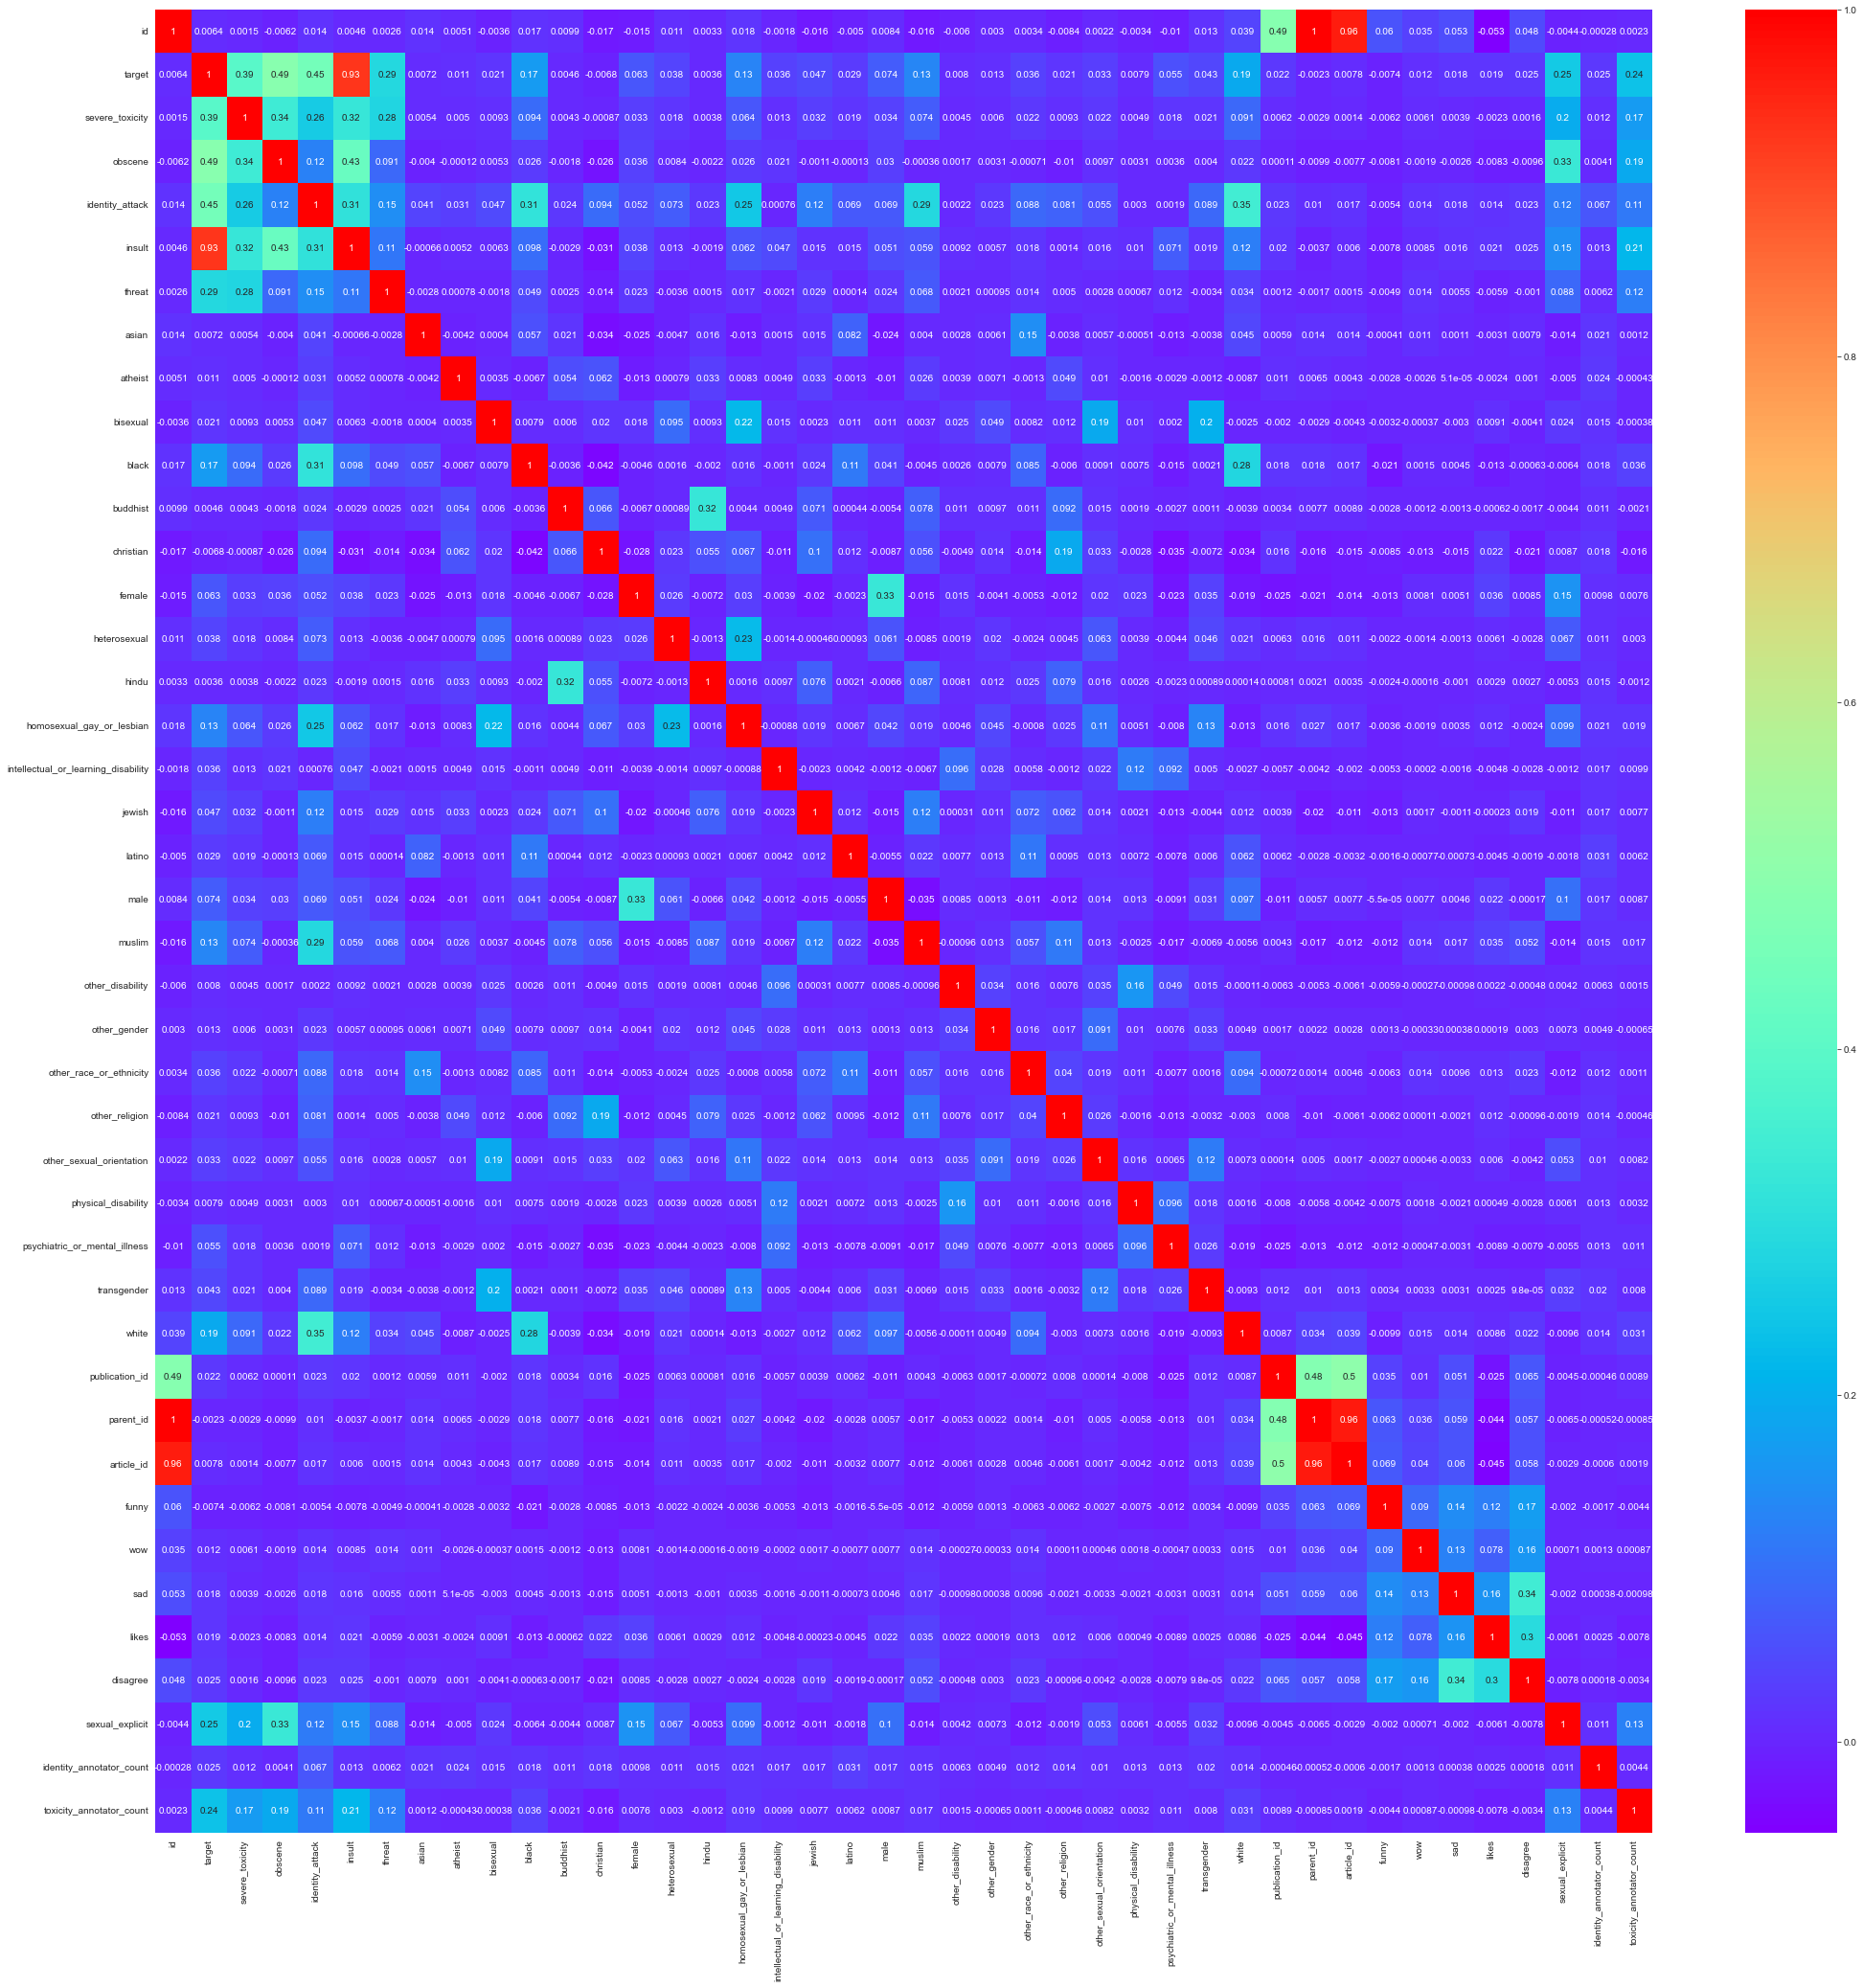

In [7]:
sns.set_style('whitegrid')
plt.figure(figsize=(35,35))
sns.heatmap(train_data.corr(),annot=True, cmap='rainbow')

In [8]:
train_data['num_words'] = [len(sent.split()) for sent in train_data['comment_text']]

In [9]:
# The total columns we have:
train_data.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count', 'num_words'],
      dtype='object')

In [10]:
train_data['num_words'].median()

35.0

<AxesSubplot:>

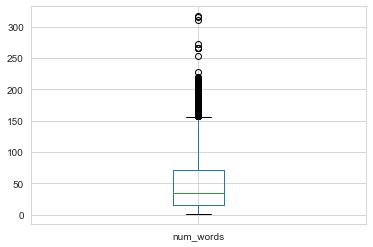

In [11]:
train_data.boxplot(column=['num_words'])

In [12]:
#For us to not train again
train_data = pd.read_csv('../data/train_filter.csv')

In [13]:
# We are saving the below code's output in order to save time
#train_data['filtered_comments']= train_data['comment_text'].apply(normalize_text)

In [14]:
train_data['filtered_comments']

0          cool like would want mother read really great ...
1          thank would make life lot le anxietyinducing k...
2                urgent design problem kudos take impressive
3                    something ill able install site release
4                                       haha guy bunch loser
                                 ...                        
1804869    maybe tax thing would collect product import r...
1804870         call people still think divine role creation
1804871                      thank right wrong follow advice
1804872    anyone quote follow exchange even apocryphal w...
1804873    student define ebd legally disable eligible sp...
Name: filtered_comments, Length: 1804874, dtype: object

In [15]:
train_data = train_data.dropna(subset=['filtered_comments'])

In [16]:
# Checking for nulls
train_data['filtered_comments'].isnull().sum()

0

In [17]:
# Setting the target value, where greater than 0.5, it will be classified as toxic, otherwise non-toxic
train_data['target']=train_data['target'].apply(lambda x: x > .5).astype('int')

## Rectifying the Class Imbalance

In [18]:
# Undersampling the dataset
X_negative= train_data[train_data['target']==0]
X_positive= train_data[train_data['target']==1]
y_negative = train_data[train_data['target']==0]['target']
y_positive = train_data[train_data['target']==1]['target']

In [19]:
X_combined = X_negative[:106438].append(X_positive)
y_combined = y_negative[:106438].append(y_positive)

In [20]:
X_combined = X_combined.sample(frac=1, random_state=42)
y_combined = y_combined.sample(frac=1, random_state=42)

## Visualizing the words using wordcloud

(-0.5, 1599.5, 799.5, -0.5)

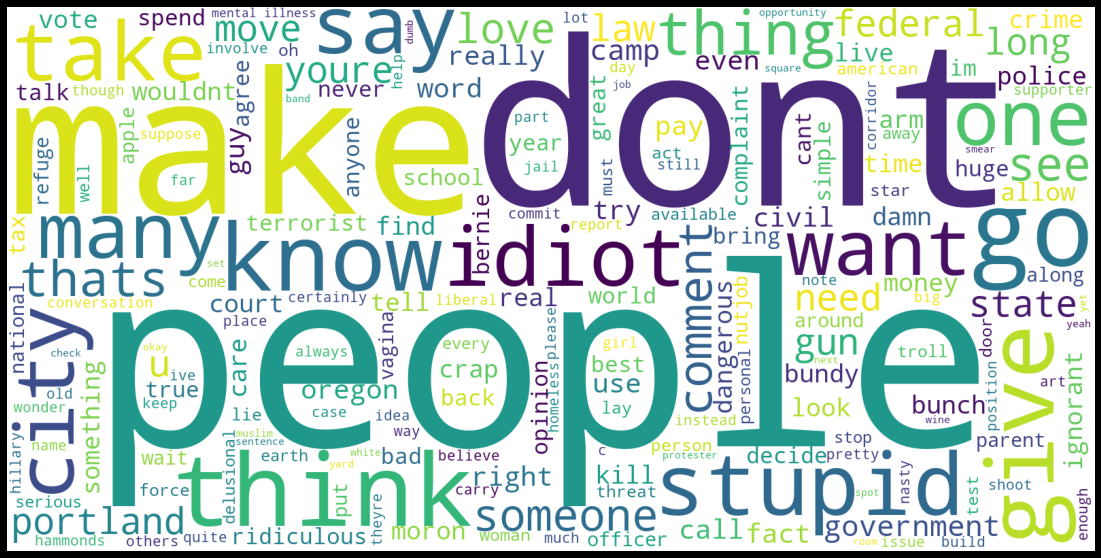

In [ ]:
# Visualizing the positive words from 100 positive comments
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(' '.join(X_positive['filtered_comments'][1:100].tolist()))
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")

(-0.5, 1599.5, 799.5, -0.5)

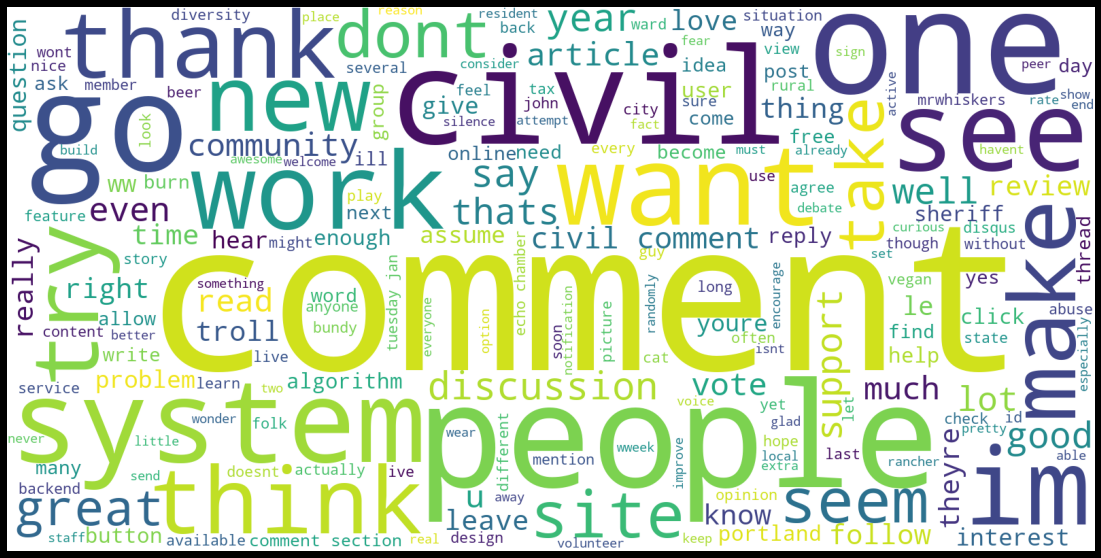

In [ ]:
# Visualizing the positive words from 100 negative comments
wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(' '.join(X_negative['filtered_comments'][1:100].tolist()))
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")

(-0.5, 1599.5, 799.5, -0.5)

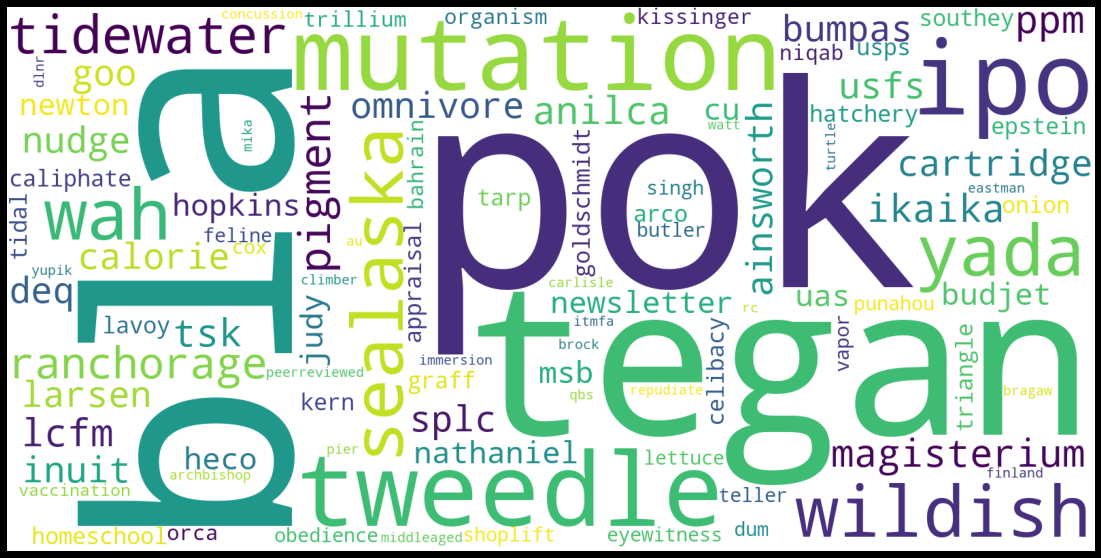

In [ ]:
# Visualizing the top words in the dataset (don't run this cell again as the vectorizer is different)
wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(' '.join(top_features))
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")

In [ ]:
indices = np.argsort(Vectorize.idf_)[::-1]

In [ ]:
features = Vectorize.get_feature_names_out()
top_n = 100
top_features = [features[i] for i in indices[:top_n]]
print(top_features)

['pok', 'bla', 'tegan', 'mutation', 'ipo', 'tweedle', 'wildish', 'wah', 'sealaska', 'yada', 'tidewater', 'ranchorage', 'pigment', 'magisterium', 'ikaika', 'ppm', 'lcfm', 'tsk', 'anilca', 'cartridge', 'usfs', 'omnivore', 'goo', 'bumpas', 'calorie', 'nudge', 'splc', 'inuit', 'larsen', 'ainsworth', 'deq', 'newsletter', 'heco', 'uas', 'msb', 'hopkins', 'cu', 'nathaniel', 'budjet', 'judy', 'newton', 'caliphate', 'arco', 'goldschmidt', 'graff', 'kern', 'tarp', 'hatchery', 'southey', 'lavoy', 'appraisal', 'usps', 'triangle', 'celibacy', 'homeschool', 'tidal', 'epstein', 'onion', 'kissinger', 'bahrain', 'niqab', 'trillium', 'organism', 'orca', 'eyewitness', 'shoplift', 'teller', 'lettuce', 'vapor', 'butler', 'com', 'singh', 'obedience', 'dum', 'punahou', 'feline', 'cox', 'vaccination', 'peerreviewed', 'mika', 'middleaged', 'itmfa', 'eastman', 'repudiate', 'bragaw', 'dlnr', 'pier', 'archbishop', 'yupik', 'watt', 'brock', 'concussion', 'immersion', 'finland', 'qbs', 'turtle', 'rc', 'au', 'carlis

## SMOTE (Oversampling)

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [ ]:
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [ ]:
X_data = train_data['filtered_comments']
y_data = train_data['target']

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_vect = tfidf_vectorizer.fit_transform(X_data)

In [ ]:
y_vect = np.array(y_data)
X_sampled, y_sampled = pipeline.fit_resample(X_vect, y_vect)

In [ ]:
X_sampled.shape

(508698, 10000)

In [ ]:
# The number of instances after performing SMOTE and Undersampling majority class
len(y_sampled)

508698

## Preprocessing: Vectorizer

In [ ]:
# Using tf-idf vectorizer as its the best
Vectorize = TfidfVectorizer(max_features=10000)
X = Vectorize.fit_transform(X_combined['filtered_comments'])

y = np.array(y_combined)

In [ ]:
# This is for SVM, because of the limitations CPU and GPU power we have at hand
Vectorize = TfidfVectorizer(max_features=1000)
X1 = Vectorize.fit_transform(X_combined['filtered_comments'][:20000])

y1 = np.array(y_combined[:20000])

Break Length to 50 mean by top 50 frequent words

# Naive Bayes

In [ ]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

In [ ]:
naive_bayes = BernoulliNB()
scores_nb = cross_val_score(naive_bayes, X, y, cv=5,scoring = 'f1_weighted')
print("Mean of Naive Bayes: ", np.mean(scores_nb), " Standard Deviation :", np.std(scores_nb))

Mean of Naive Bayes:  0.7544356716564892  Standard Deviation : 0.001823816485876652


In [ ]:
naive_bayes = BernoulliNB()
scores_nb_sampled = cross_val_score(naive_bayes, X_sampled, y_sampled, cv=5,scoring = 'f1_weighted')
print("Mean of Naive Bayes(sampling): ", np.mean(scores_nb_sampled), " Standard Deviation :", np.std(scores_nb_sampled))

Mean of Naive Bayes(sampling):  0.7107156999295852  Standard Deviation : 0.004770516043021674


## Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logistic_regression = LogisticRegression(max_iter=10000)
scores_lr = cross_val_score(logistic_regression, X, y, cv=5,scoring = 'f1_weighted')
print("Mean of Logistic Regression: ", np.mean(scores_lr), " Standard Deviation :", np.std(scores_lr))

Mean of Logistic Regression:  0.9059540079854752  Standard Deviation : 0.000997183133199154


In [ ]:
scores_lr_sampled = cross_val_score(logistic_regression, X_sampled, y_sampled, cv=5,scoring = 'f1_weighted')
print("Mean of Logistic Regression(sampling): ", np.mean(scores_lr_sampled), " Standard Deviation :", np.std(scores_lr_sampled))

Mean of Logistic Regression(sampling):  0.8542915100331475  Standard Deviation : 0.026132411481044063


## SVM

In [ ]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf')
scores_svc = cross_val_score(svc, X1, y1, cv=5,scoring = 'f1_weighted')
print("Mean of SVM:", np.mean(scores_svc), " Standard Deviation :", np.std(scores_svc))

Mean of SVM: 0.8392711195080593  Standard Deviation : 0.0008070535022016298


## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
clf = DecisionTreeClassifier(max_depth=1000)

In [ ]:
scores_dtree = cross_val_score(clf, X, y, cv=5,scoring = 'f1_weighted')
print("Mean of Decision Tree Classifier: ", np.mean(scores_dtree), " Standard Deviation :", np.std(scores_dtree))

Mean of Decision Tree Classifier:  0.8515591864454901  Standard Deviation : 0.0016953756664359733


In [ ]:
clf1 = DecisionTreeClassifier(max_depth=500,max_features='auto')
scores_dtree = cross_val_score(clf1, X, y, cv=5,scoring = 'f1_weighted')
print("Mean of Decision Tree Classifier: ", np.mean(scores_dtree), " Standard Deviation :", np.std(scores_dtree))

Mean of Decision Tree Classifier:  0.7944982548137001  Standard Deviation : 0.0060843687664576636


In [ ]:
clf1 = DecisionTreeClassifier(criterion='entropy',max_depth=500,max_features='auto')
scores_dtree = cross_val_score(clf1, X, y, cv=5,scoring = 'f1_weighted')
print("Mean of Decision Tree Classifier: ", np.mean(scores_dtree), " Standard Deviation :", np.std(scores_dtree))

Mean of Decision Tree Classifier:  0.7970642992366546  Standard Deviation : 0.005098524518894265


In [ ]:
clf1 = DecisionTreeClassifier(max_depth=1000,max_features='auto')
scores_dtree = cross_val_score(clf1, X, y, cv=5,scoring = 'f1_weighted')
print("Mean of Decision Tree Classifier: ", np.mean(scores_dtree), " Standard Deviation :", np.std(scores_dtree))

Mean of Decision Tree Classifier:  0.7937184066478791  Standard Deviation : 0.006015505541039457


In [ ]:
clf1 = DecisionTreeClassifier(max_depth=500,min_samples_split=5)
scores_dtree = cross_val_score(clf1, X, y, cv=5,scoring = 'f1_weighted')
print("Mean of Decision Tree Classifier: ", np.mean(scores_dtree), " Standard Deviation :", np.std(scores_dtree))

Mean of Decision Tree Classifier:  0.8534695231584237  Standard Deviation : 0.00214977165863276


In [ ]:
clf1 = DecisionTreeClassifier(max_depth=200)
scores_dtree = cross_val_score(clf1, X, y, cv=5,scoring = 'f1_weighted')
print("Mean of Decision Tree Classifier: ", np.mean(scores_dtree), " Standard Deviation :", np.std(scores_dtree))

Mean of Decision Tree Classifier:  0.8520938072740079  Standard Deviation : 0.002189879697358379


In [ ]:
clf1 = DecisionTreeClassifier(max_depth=200)
scores_dtree = cross_val_score(clf1, X_sampled, y_sampled, cv=5,scoring = 'f1_weighted')
print("Mean of Decision Tree Classifier:(sampling) ", np.mean(scores_dtree), " Standard Deviation :", np.std(scores_dtree))

Mean of Decision Tree Classifier:(sampling)  0.860553118699778  Standard Deviation : 0.013661884514698274


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=500,random_state=13)

In [ ]:
scores_rfc = cross_val_score(rfc, X, y, cv=5,scoring = 'f1_weighted')

In [ ]:
print("Mean of Random Forest:", np.mean(scores_rfc), " Standard Deviation :", np.std(scores_rfc))

Mean of Random Forest: 0.8893692326879513  Standard Deviation : 0.0013443354486324878


## Graph Metrics of the ML diagrams

AUC =  0.844767471598044


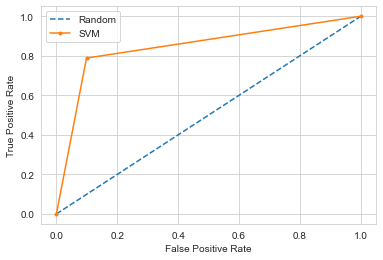

In [ ]:
# Don't run the cell, just for comparison
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y1_test, svc_pred)
auc_svm = auc(fpr_svm, tpr_svm)
print("AUC = ",auc_svm)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='Random')
pyplot.plot(fpr_svm, tpr_svm, marker='.', label='SVM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

AUC =  0.8887258547014661


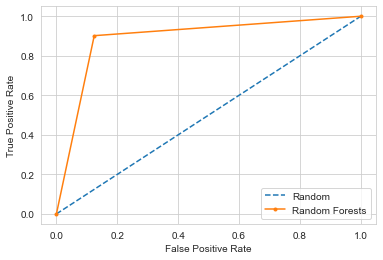

In [ ]:
# Don't run the cell, just for comparison
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_test, predictions_rfc)
auc_rfc = auc(fpr_rfc, tpr_rfc)
print("AUC = ",auc_rfc)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='Random')
pyplot.plot(fpr_rfc, tpr_rfc, marker='.', label='Random Forests')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

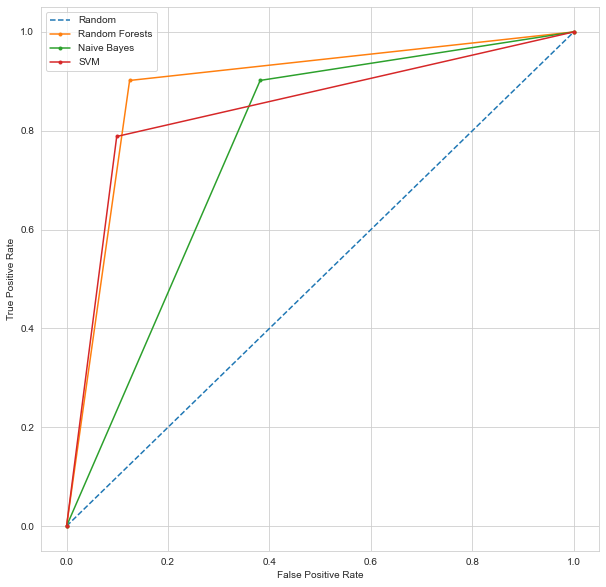

In [ ]:
# This we ran using train test split to compare AUC graphs, don't run again 
plt.figure(figsize=(10,10))
pyplot.plot([0,1], [0,1], linestyle='--', label='Random')
pyplot.plot(fpr_rfc, tpr_rfc, marker='.', label='Random Forests')
pyplot.plot(fpr_bayes, tpr_bayes, marker='.', label='Naive Bayes')
pyplot.plot(fpr_svm, tpr_svm, marker='.', label='SVM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# Perceptron Based Classifiers
1.   LSTM(self train embedding layer)
2.   LSTM(transfer learning)

In [67]:
import numpy
from keras.callbacks import EarlyStopping
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Bidirectional,Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import text, sequence
from sklearn.preprocessing import LabelEncoder
#random seed for reproducibility
numpy.random.seed(7)


In [68]:
X = X_combined['filtered_comments']
Y = y_combined

X_train_cleaned, X_test_cleaned, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [69]:
X_train_sequences = X_train_cleaned.apply(text_to_word_sequence)
X_test_sequences = X_test_cleaned.apply(text_to_word_sequence)
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(X_train_sequences.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
X_train = tokenizer.texts_to_sequences(X_train_sequences)
X_test = tokenizer.texts_to_sequences(X_test_sequences)
vocab_size = len(tokenizer.word_index) + 1
max_comment_length = 50
X_train = sequence.pad_sequences(X_train, maxlen=max_comment_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_comment_length)

Found 103508 unique tokens.


In [70]:
encoder = LabelEncoder()
labels = encoder.fit_transform(y_train)
y_labels = encoder.fit_transform(y_test)
y_combined.value_counts()

0    106438
1    106437
Name: target, dtype: int64

In [71]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, labels, test_size=0.2, random_state=42)

In [54]:
# create the model
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

embedding_vecor_length = 200
model_self = Sequential()
model_self.add(Embedding(vocab_size, embedding_vecor_length, input_length=50))
model_self.add(LSTM(50))
model_self.add(Dense(1, activation='sigmoid'))
model_self.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_self.summary())
model_self.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=3, batch_size=128,callbacks=[early_stopping_monitor])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 50, 200)           20701800  
                                                                 
 lstm_9 (LSTM)               (None, 50)                50200     
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 20,752,051
Trainable params: 20,752,051
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
1065/1065 [==============================] - 329s 307ms/step - loss: 0.2742 - accuracy: 0.8854 - val_loss: 0.2223 - val_accuracy: 0.9120
Epoch 2/3
1065/1065 [==============================] - 329s 309ms/step - loss: 0.1680 - accuracy: 0.9340 - val_loss: 0.2253 - val_accuracy: 0.9117


In [57]:
preds=model_self.predict(X_test)

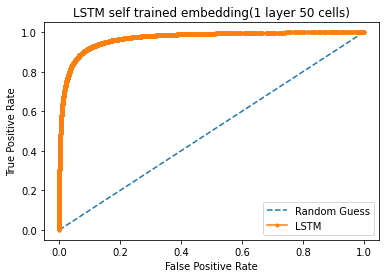

AUC-ROC score 0.96929365962163


In [58]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_labels, preds)
auc_keras = auc(fpr_keras, tpr_keras)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='Random Guess')
pyplot.plot(fpr_keras, tpr_keras, marker='.', label='LSTM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.title("LSTM self trained embedding(1 layer 50 cells)")
pyplot.show()
print("AUC-ROC score "+ str(auc_keras))

In [59]:
from sklearn.metrics import f1_score

threshold = 0.45
y_pred=np.apply_along_axis(lambda x: x > threshold,0,preds)
#y_pred = (preds[:, 1] > threshold).astype('float')
print("Confusion Matrix ")
print(confusion_matrix(y_test, y_pred))
print("F1_Score ")
print(f1_score(y_test,y_pred))
print("Accuracy Score ")
print(accuracy_score(y_test,y_pred))

Confusion Matrix 
[[19146  2207]
 [ 1634 19588]]
F1_Score 
0.9107097194132553
Accuracy Score 
0.9097827363476219


# LSTM with Transfer Learning

In [60]:
def build_matrix(word_index, path):
    embedding_index = KeyedVectors.load(path, mmap='r')
    embedding_matrix = np.zeros((len(word_index) + 1, 200))
    for word, i in word_index.items():
        for candidate in [word, word.lower()]:
            if candidate in embedding_index:
                embedding_matrix[i] = embedding_index[candidate]
                break
    return embedding_matrix
EMBEDDING_FILES = [
    '../data/glove.twitter.27B.200d.gensim'
]
from gensim.models import KeyedVectors
embedding_matrix = np.concatenate(
    [build_matrix(tokenizer.word_index, f) for f in EMBEDDING_FILES], axis=-1)

In [62]:
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

model_trans = Sequential()
model_trans.add(Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=True, input_length=50))
model_trans.add(LSTM(50))
model_trans.add(Dense(1, activation='sigmoid'))
model_trans.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_trans.summary())
model_trans.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5, batch_size=128 ,callbacks=[early_stopping_monitor])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 50, 200)           20701800  
                                                                 
 lstm_11 (LSTM)              (None, 50)                50200     
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 20,752,051
Trainable params: 20,752,051
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
1065/1065 [==============================] - 341s 318ms/step - loss: 0.2695 - accuracy: 0.8884 - val_loss: 0.2190 - val_accuracy: 0.9140
Epoch 2/5
1065/1065 [==============================] - 324s 304ms/step - loss: 0.1758 - accuracy: 0.9313 - val_loss: 0.2120 - val_accuracy: 0.9155


In [82]:
preds=model_trans.predict(X_test)

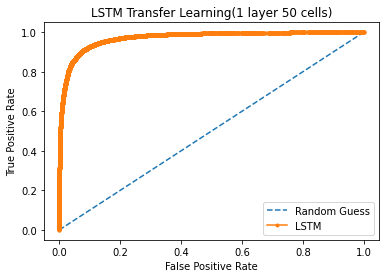

AUC-ROC score 0.9717036362033775


In [83]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_labels, preds)
auc_keras = auc(fpr_keras, tpr_keras)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='Random Guess')
pyplot.plot(fpr_keras, tpr_keras, marker='.', label='LSTM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.title("LSTM Transfer Learning(1 layer 50 cells)")
pyplot.show()
print("AUC-ROC score "+ str(auc_keras))

In [64]:
from sklearn.metrics import f1_score

threshold = 0.45
y_pred=np.apply_along_axis(lambda x: x > threshold,0,preds)
#y_pred = (preds[:, 1] > threshold).astype('float')
print("Confusion Matrix ")
print(confusion_matrix(y_test, y_pred))
print("F1_Score ")
print(f1_score(y_test,y_pred))
print("Accuracy Score ")
print(accuracy_score(y_test,y_pred))

Confusion Matrix 
[[19071  2282]
 [ 1465 19757]]
F1_Score 
0.9133861907954047
Accuracy Score 
0.9119906048150322
